In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
print(sklearn.__version__)
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
%matplotlib inline

0.22.1


In [266]:
### ATC data from DfT
vol = pd.read_csv('../DfT/DfT.csv')
vol['loc_key'] = vol.apply(lambda row: str(row['Site'])+row['Direction'][0], axis=1)
vol['datetime_key'] = vol.apply(lambda row: str(row['Date'])+'_'+str(row['Hour']), axis=1)
vol['site_id'] = vol['Site'].astype(int)
# print(vol.nunique(), np.max(vol['Date']), np.min(vol['Date']))
vol = vol[['loc_key', 'datetime_key', 'site_id', 'Volume']]
# vol.head()

### Travel time data from Google API
speed = pd.read_csv('../Google/Google.csv')
speed = speed.fillna(value={'Direction': '-'})
speed['loc_key'] = speed.apply(lambda row: str(row['Site'])+row['Direction'][0], axis=1)
speed['datetime_key'] = speed.apply(lambda row: str(row['Date'])+'_'+str(row['Hour']), axis=1)
# print(speed.nunique(), np.max(speed['Date']), np.min(speed['Date']))
speed = speed[['loc_key', 'datetime_key', 'distance', 'duration', 'duration_in_traffic', 'MajorMinor', 'Note', 'Road Class', 'dft_capacity', 'speed_limit(kph)']]
# speed.head()

### merge volume and speed data by location and time
data = pd.merge(vol, speed, how='inner', on=['loc_key', 'datetime_key'])
print('Before merge, ACT has {} records, Google has {} records. Merged data has {} records'.format(vol.shape[0], speed.shape[0], data.shape[0]))
# data[data['loc_key']=='11N']
print(data.groupby(['loc_key']).agg({'Note': 'first', 'Road Class': 'first', 'MajorMinor': 'first', 'dft_capacity': 'first'}))

Unnamed: 0      30994
Site               20
Date               34
Hour               24
Direction           4
Volume           1410
loc_key            40
datetime_key      816
site_id            20
dtype: int64 2016-03-31 2016-02-27


/Users/bingyu/anaconda3/envs/cities/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Unnamed: 0             34989
_sent_time_stamp       13800
distance                  51
duration                  84
duration_in_traffic      554
Orig_lat                  72
Orig_lng                  72
Dest_lat                  72
Dest_lng                  72
MajorMinor                 2
Borough                   25
Lane_1_x                   4
Lane_2                     2
Note                       3
Date                      22
Hour                      24
Direction                  5
Site                      37
Roadname                  37
Lane_1_y                   4
Road Class                 5
Lane_count                 3
dft_capacity               5
speed_limit(kph)           4
loc_key                   71
datetime_key             484
dtype: int64 2016-03-21 2016-02-29
Before merge, ACT has 30994 records, Google has 34989 records. Merged data has 17745 records
                    Note    Road Class MajorMinor  dft_capacity
loc_key                                               

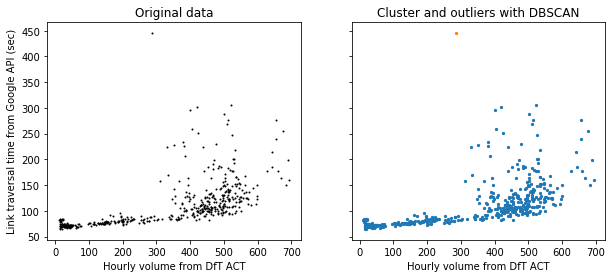

In [192]:
sample_data = data.loc[data['loc_key']=='11N', ['Volume', 'duration_in_traffic']].values

### plot original data
fig, ax = plt.subplots(1,2, figsize=(10, 4), sharey=True)
ax[0].scatter(sample_data[:,0], sample_data[:,1], s=1, c='k')
ax[0].set_xlabel('Hourly volume from DfT ACT')
ax[0].set_ylabel('Link traversal time from Google API (sec)')
ax[0].set_title('Original data')

### plot clustered data
### DBSCAN code based on: https://machinelearningmastery.com/clustering-algorithms-with-python/
### DBSCAN explanation: https://scikit-learn.org/stable/modules/clustering.html#dbscan
model = DBSCAN(eps=1650/21, min_samples=10)
yhat = model.fit_predict(sample_data)
clusters = np.unique(yhat)
for cluster in clusters:
    row_ix = np.where(yhat == cluster)
    if cluster==0: c=u'#1f77b4'
    else: c=u'#ff7f0e' 
    ax[1].scatter(sample_data[row_ix, 0], sample_data[row_ix, 1], s=5, c=c, label=cluster)
ax[1].set_xlabel('Hourly volume from DfT ACT')
ax[1].set_title('Cluster and outliers with DBSCAN')
# plt.legend()
pyplot.show()

['9N', '9S', '11N', '11S', '15N', '15S', '19E', '19W', '22N', '22S', '25W', '27E', '27W', '31N', '31S', '33N', '33S', '35N', '35S', '36N', '36S', '39N', '39S', '40E', '40W', '42N', '42S', '43E', '43W', '48N', '48S', '66N', '66S', '67N', '67S', '68E', '68W', '74N', '74S']
Data has 17745 points before removing outliers, 17712 after removing outliers


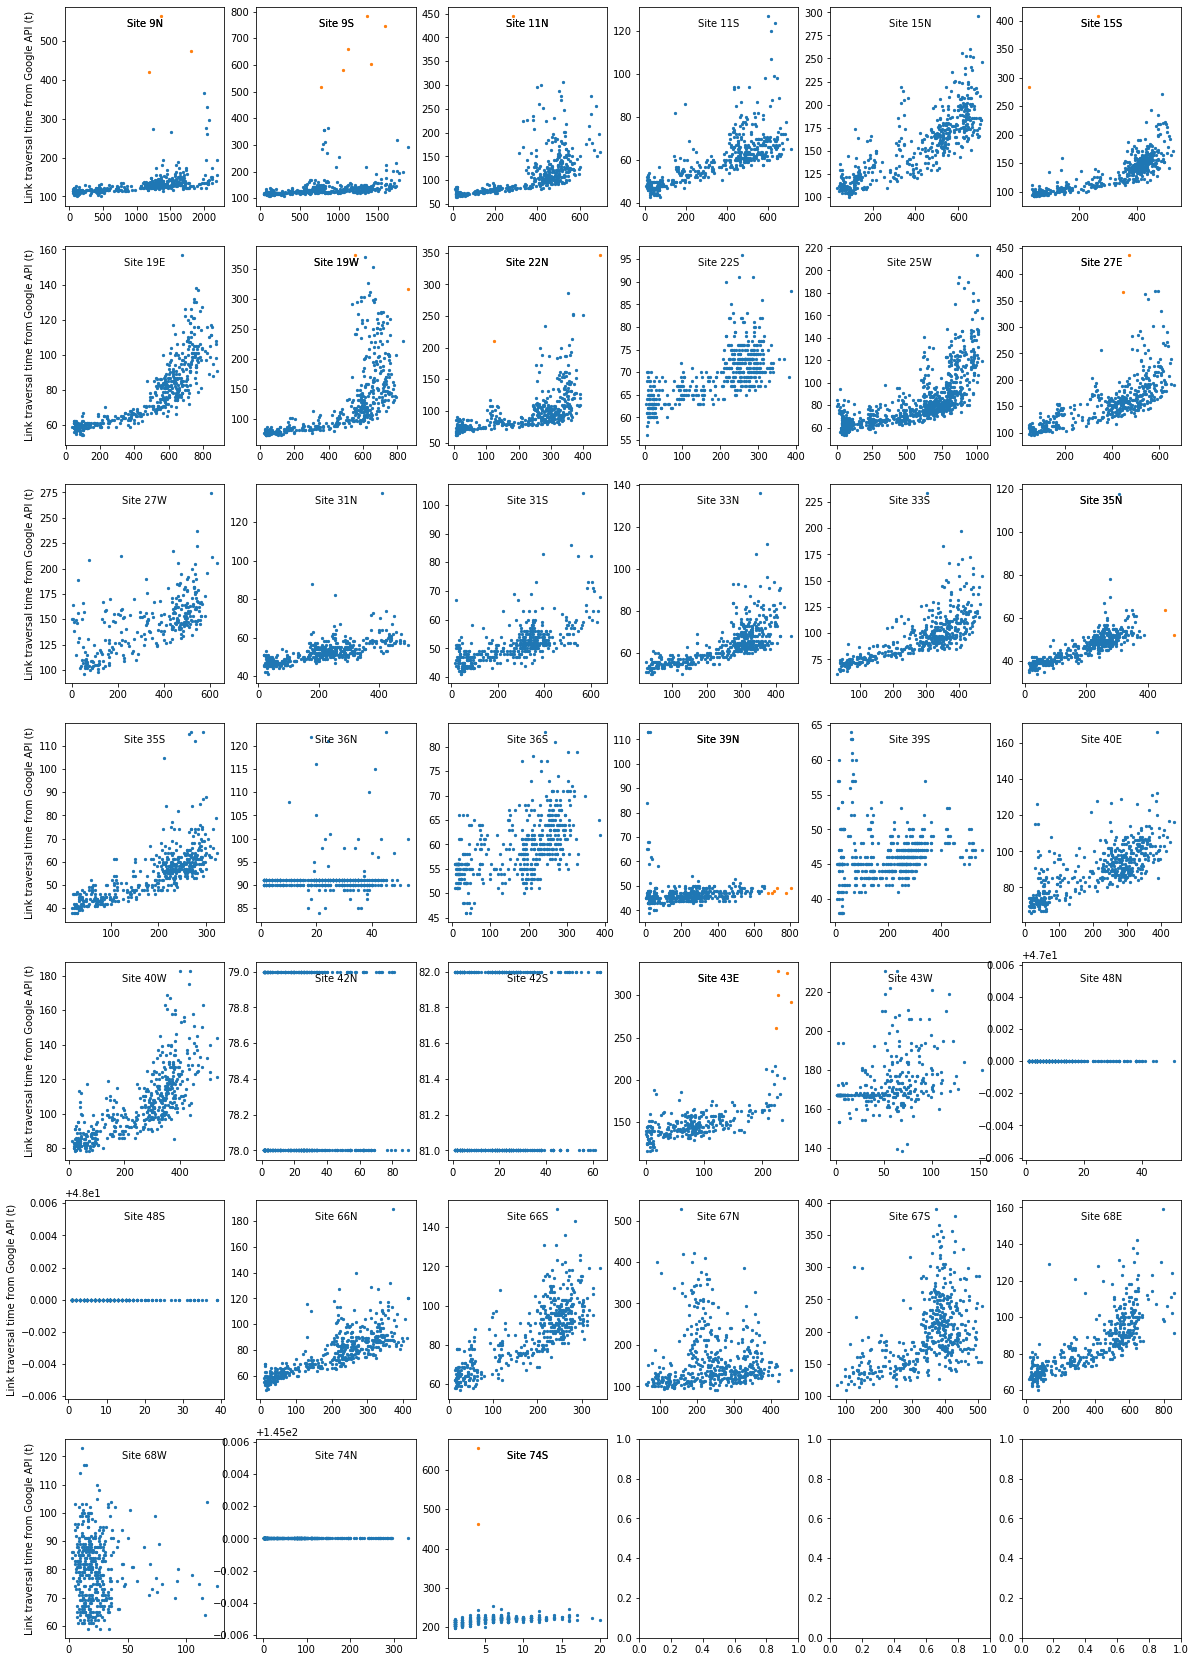

In [271]:
### Showing clustering results for all data
loc_list = data.groupby(['site_id', 'loc_key']).size().index.get_level_values('loc_key').tolist()
print(loc_list)
# print(data.groupby(['site_id', 'loc_key']).size())

filtered_data_list = []
loc_cnt = -1  
fig, ax = plt.subplots(7,6, figsize=(20, 30))
for loc_cnt in range(len(loc_list)):
    row = loc_cnt//6
    col = loc_cnt%6
    sample_data = data.loc[data['loc_key']==loc_list[loc_cnt], ['Volume', 'duration_in_traffic']].values
    sample_data_capacity = data.loc[data['loc_key']==loc_list[loc_cnt], 'dft_capacity'].values[0]
    model = DBSCAN(eps=sample_data_capacity/21, min_samples=10)
    yhat = model.fit_predict(sample_data)
    clusters = np.unique(yhat)
    for cluster in clusters:
        row_ix = np.where(yhat == cluster)
        if cluster==0: c=u'#1f77b4'
        else: c=u'#ff7f0e' 
        ax[row, col].scatter(sample_data[row_ix, 0], sample_data[row_ix, 1], s=5, c=c, label=cluster)
        ax[row, col].text(.5,.9,'Site {}'.format(loc_list[loc_cnt]), horizontalalignment='center', transform=ax[row, col].transAxes)
        if row==9: ax[row, col].set_xlabel('Hourly volume from DfT ACT')
        if col==0: ax[row, col].set_ylabel('Link traversal time from Google API (t)')
#         ax[row, col].legend()
    filtered_data_list.append(data.loc[data['loc_key']==loc_list[loc_cnt]].iloc[np.where(yhat == 0)])
filtered_data = pd.concat(filtered_data_list)
print('Data has {} points before removing outliers, {} after removing outliers'.format(data.shape[0], filtered_data.shape[0]))

In [274]:
### normalize volume and travel time
### free flow time (travel time normalization factor): lowest 95 percentile of all observed travel time
### saturation volume (volume normalization factor): average volume of 10 observations when travel_time/free_flow_time is closest to 2.
data_grp = filtered_data[~filtered_data['loc_key'].isin(['36N', '42N', '42S', '48N', '48S', '74N', '74S', '22S', '36S', '39S', '43W'])].groupby('loc_key')
### 22S, 36S, 39S, 43W: maximum delay < 1.8
data_norm_list = []
for nm, grp in data_grp:
    df = grp.copy()
    df['t_95pct'] = np.percentile(df['duration_in_traffic'], 5)
    df['t_norm'] = df['duration_in_traffic']/df['t_95pct']
    sat_df = df[(df['t_norm']>1.8) & (df['t_norm']<2.2)]
    if sat_df.shape[0] == 0:
        print(nm)
        sat_df = df.copy()
        sat_df['abs_t_norm_minus_2'] = np.abs(sat_df['t_norm'] - 2)
        sat_df = sat_df.nsmallest(30, 'abs_t_norm_minus_2')
    df['v_sat'] = np.percentile(sat_df['Volume'], 95)#np.average(sat_df['Volume'])
    df['v_norm'] = df['Volume']/df['v_sat']
#     if nm=='9S': print(sat_df, df.iloc[0])
    data_norm_list.append(df)
data_norm = pd.concat(data_norm_list)
# data_norm[data_norm['loc_key']=='9S'].head()

43E
9N


{'11N': 466, '11S': 467, '15N': 467, '15S': 465, '19E': 467, '19W': 465, '22N': 465, '25W': 932, '27E': 465, '27W': 287, '31N': 467, '31S': 467, '33N': 467, '33S': 467, '35N': 465, '35S': 467, '39N': 461, '40E': 467, '40W': 467, '43E': 324, '66N': 467, '66S': 467, '67N': 467, '67S': 467, '68E': 423, '68W': 423, '9N': 464, '9S': 461}


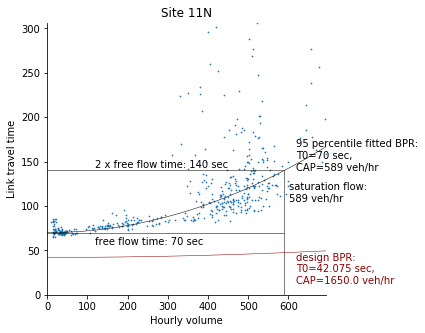

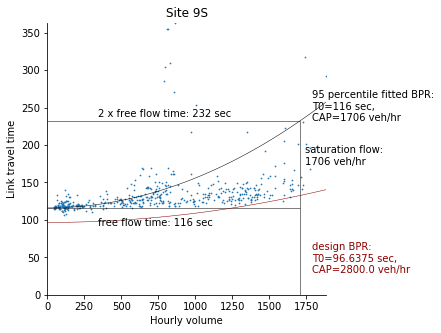

In [279]:
print(data_norm.groupby('loc_key').size().to_dict())
selected_sites = ['11N', '9S']
for site in selected_sites:
    df = data_norm.loc[data_norm['loc_key']==site]
    fft = df['t_95pct'].iloc[0]
    cap = df['v_sat'].iloc[0]
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title('Site {}'.format(site))
    ax.scatter(df['Volume'], df['duration_in_traffic'], s=0.5)
    ax.set_xlim([0, np.max(df['Volume'])])
    ax.set_ylim([0, np.max(df['duration_in_traffic'])])
    ax.set_xlabel('Hourly volume')
    ax.set_ylabel('Link travel time')
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    # Add capacity reference
    ax.vlines(x=cap, ymin=0, ymax=fft*2, lw=0.5)
    ax.hlines(y=fft*2, xmin=0, xmax=cap, lw=0.5)
    ax.hlines(y=fft, xmin=0, xmax=cap, lw=0.5)
    ax.text(cap*1.02, fft*1.5, 'saturation flow:\n{} veh/hr'.format(int(cap)))
    ax.text(cap/5, fft*2.05, '2 x free flow time: {} sec'.format(int(fft*2)))
    ax.text(cap/5, fft*0.8, 'free flow time: {} sec'.format(int(fft)))
    ### Add BPR curve
    x_obs = np.linspace(0, np.max(df['Volume'])*1.1, 50)
    y_obs = (1 + (x_obs/cap)**2)*fft
    ax.plot(x_obs, y_obs, c='k', lw=0.5, label='Obs')
    ax.text(cap*1.05, fft*2, '95 percentile fitted BPR:\nT0={} sec,\nCAP={} veh/hr'.format(int(fft), int(cap)), c='k')
    ### Add DfT capacity and speed limit
    dft_fft = df['distance'].iloc[0]/df['speed_limit(kph)'].iloc[0]*3.6 ### Believed free flow time in seconds
    dft_cap = df['dft_capacity'].iloc[0]
    y_dft = (1 + (x_obs/dft_cap)**2)*dft_fft
    ax.plot(x_obs, y_dft, c='darkred', lw=0.5, label='DfT BPR')
    ax.text(cap*1.05, dft_fft*0.3, 'design BPR:\nT0={} sec,\nCAP={} veh/hr'.format(dft_fft, dft_cap), c='darkred')